In [33]:

import asyncio
from dotenv import load_dotenv
load_dotenv()
import nest_asyncio
nest_asyncio.apply()
import aiohttp
import os
import json
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

import cv2
import numpy as np

from anthropic import AsyncAnthropic
from openai import AsyncOpenAI

from transparent_background import Remover
lyrics="""
Verse 1:
When yer sailin' on the seas (yo-ho!)
And you've got some tasty treats (arr!)
Don't forget to share with mates
That's what every pirate states! (ahoy!)

Chorus:
Sharin' is carin', me hearties know
It fills our hearts with a friendly glow
Whether it's treasure or a yummy snack
Sharin' with others keeps the smiles on track! (yo-ho!)

Verse 2:
If you've got a shiny coin (avast!)
Or a scrumptious candy growin'
Pass it 'round to all yer crew
Sharin' makes the skies more blue! (arr!)

Chorus:
Sharin' is carin', me hearties know
It fills our hearts with a friendly glow

Whether it's treasure or a yummy snack
Sharin' with others keeps the smiles on track! (yo-ho!)
"""
prompt = """
You are given lyrics from a song that I created.
You are in charge of making a list of pictures relating to the song
The pictures should be relevant to the text and be of individual items only.
Each description should start with: a simple kid friendly cartoon illustration of...
End with: on a white background
Please give me 6 descriptions.

Return a valid json list of objects:
description: description of the item
word: One word description
learning: connection between the item and the song that can be understood by a three year old
Example output
[
    {
      description: "a simple kid friendly cartoon illustration of a pirate hat on a white background",
      word: "hat",
      learning: "Pirates wear hats"
    }
]
"""
async def generate_text(text, script):
    client = AsyncAnthropic(
        # This is the default and can be omitted
        api_key=os.environ.get("ANTHROPIC_API_KEY"),
    )

    message = await client.messages.create(
        temperature=0.5,
        max_tokens=1024,
        messages=[
            {
                "role": "user",
                "content": text + script,
            },
            {"role": "assistant", "content": "["},
        ],
        model="claude-3-opus-20240229",
    )

    return message.content

In [34]:
pictures = asyncio.run(generate_text(lyrics, prompt))

In [35]:
pictures = json.loads("["+pictures[0].text)

In [36]:
pictures

[{'description': 'a simple kid friendly cartoon illustration of a pirate ship on a white background',
  'word': 'ship',
  'learning': 'Pirates sail on ships'},
 {'description': 'a simple kid friendly cartoon illustration of a treasure chest on a white background',
  'word': 'treasure',
  'learning': 'Pirates share their treasure with friends'},
 {'description': 'a simple kid friendly cartoon illustration of a candy on a white background',
  'word': 'candy',
  'learning': 'Sharing candy makes everyone happy'},
 {'description': 'a simple kid friendly cartoon illustration of a smiling face on a white background',
  'word': 'smile',
  'learning': "Sharing brings smiles to everyone's faces"},
 {'description': 'a simple kid friendly cartoon illustration of a pirate flag on a white background',
  'word': 'flag',
  'learning': 'Pirates have their own special flags'}]

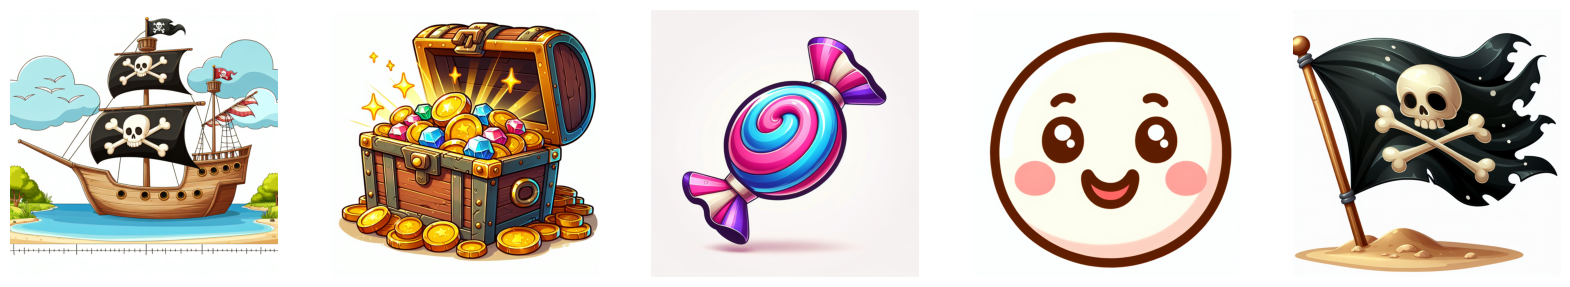

In [37]:
async def fetch_image_binary(url):
    async with aiohttp.ClientSession() as session:
        async with session.get(url) as response:
            # Make sure the request was successful
            if response.status == 200:
                # Read and return the binary content of the image
                return await response.read()
            else:
                # Handle possible HTTP errors (e.g., 404 Not Found) here if needed
                return None


async def generate_image(description):
    client = AsyncOpenAI()
    response = await client.images.generate(
        model="dall-e-3",
        prompt=description,
        size="1024x1024",
        quality="standard",
        n=1,
    )
    image_binary = await fetch_image_binary(response.data[0].url)
    return image_binary


async def generate_images(pictures):
    tasks = [generate_image(picture['description']) for picture in pictures]
    imgs = await asyncio.gather(*tasks)
    return imgs

imgs = asyncio.run(generate_images(pictures))

# Set up the matplotlib figure and axes
fig, axes = plt.subplots(1, len(imgs), figsize=(20, 5))  # Adjust figsize as needed

for ax, img in zip(axes, imgs):
    image = Image.open(BytesIO(img))
    ax.imshow(image)
    ax.axis("off")  # Hide axes ticks

plt.show()

In [38]:
remover = Remover()

Settings -> Mode=base, Device=mps:0, Torchscript=disabled


In [39]:
def display_on_solid_background(pil_img, background_color=(255, 0, 0)):
    """
    Paste the PIL Image on a solid background color to visualize transparency.
    
    Args:
    - pil_img: A PIL Image object, expected to have an alpha channel.
    - background_color: A tuple representing the RGB color of the background.
    
    Returns:
    - A PIL Image object with the original image pasted on a solid background.
    """
    # Create a background image of the same size as the input image, filled with the background_color
    background = Image.new("RGB", pil_img.size, background_color)
    # Convert the input image to RGBA if not already in that mode
    pil_img_rgba = pil_img.convert("RGBA")
    # Paste the input image onto the background, using its alpha channel as a mask
    background.paste(pil_img_rgba, (0, 0), pil_img_rgba)
    return background

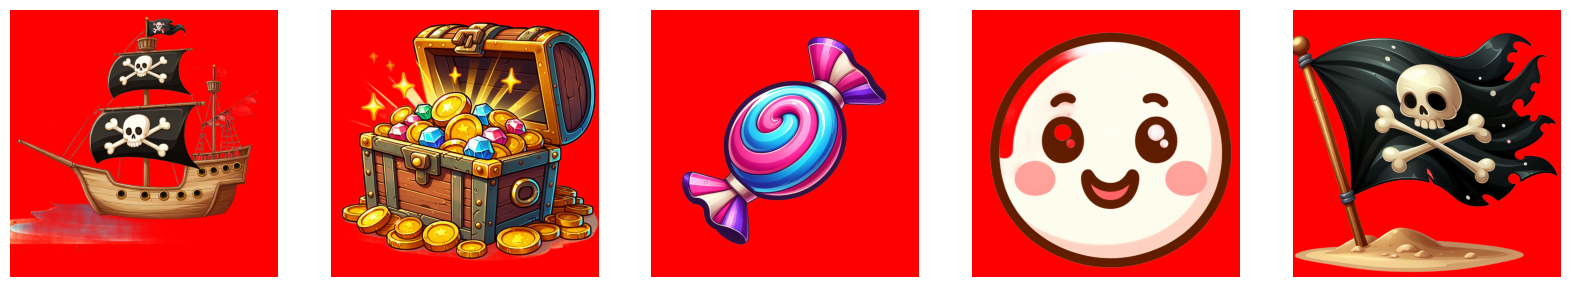

In [40]:
# Assuming `imgs` is a list of binary data for each image
removed_background_images = [remover.process(Image.open(BytesIO(img))) for img in imgs]

fig, axes = plt.subplots(1, len(removed_background_images), figsize=(20, 5))
for ax, img in zip(axes, removed_background_images):
    # Display each image on a red background
    img_on_bg = display_on_solid_background(img, background_color=(255, 0, 0))
    ax.imshow(img_on_bg)
    ax.axis("off")
plt.show()